In [1]:
import os
import re
import json
import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import hiplot as hip

from IPython.display import display

In [2]:
CHECKPOINT_ROOTS = [
    '../checkpoints/classification_from_scratch/',
    '../checkpoints/classification_with_denoising_bernoulli/',
    '../checkpoints/classification_with_denoising_gaussian',
    '../checkpoints/classification_with_rotation',
    '../checkpoints/classification_with_pirl',
]

In [3]:
data = {}
for ckpt_root in CHECKPOINT_ROOTS:

    config_files = glob.glob(os.path.join(ckpt_root, '**/*/configs.json'), recursive=True)
    config_files = [os.path.normpath(p) for p in config_files]
    
    for config_file in config_files:
    
        try:
            # Open `configs.json`
            with open(config_file, 'r') as fp:
                config = json.load(fp)
            # Open 'best_history.json'
            history_file = os.path.join(os.path.split(config_file)[0], 'best_history.json')
            with open(history_file, 'r') as fp:
                history = json.load(fp)
        except FileNotFoundError:
            continue
        
        def get_pretext(config):
            p = config.get('pretext')
            if p is None:
                pretext = 'scratch'
            elif p == 'denoising':
                pretext = f"denoising_{config.get('noise_type')}"
            else:
                pretext = p
            return pretext
        
        d = {
            'data_index': config.get('data_index'),
            'in_channels': config.get('in_channels'),
            'smoothing': config.get('smoothing'),
            'labeled': config.get('labeled'),
            'pretext': get_pretext(config),
            'freeze': len(config.get('freeze')),
            'best_epoch': history['epoch'],
            'test_accuracy': history['accuracy']['test'],
            'valid_accuracy': history['accuracy']['valid'],
            'train_accuracy': history['accuracy']['train'],
            #'test_f1': history['f1']['test'],
            #'valid_f1': history['f1']['valid'],
            #'train_f1': history['f1']['train'],
            'test_loss': history['loss']['test'],
            'valid_loss': history['loss']['valid'],
            'train_loss': history['loss']['train'],
        }
    
        data[config['checkpoint_dir']] = d

In [4]:
len(data)

855


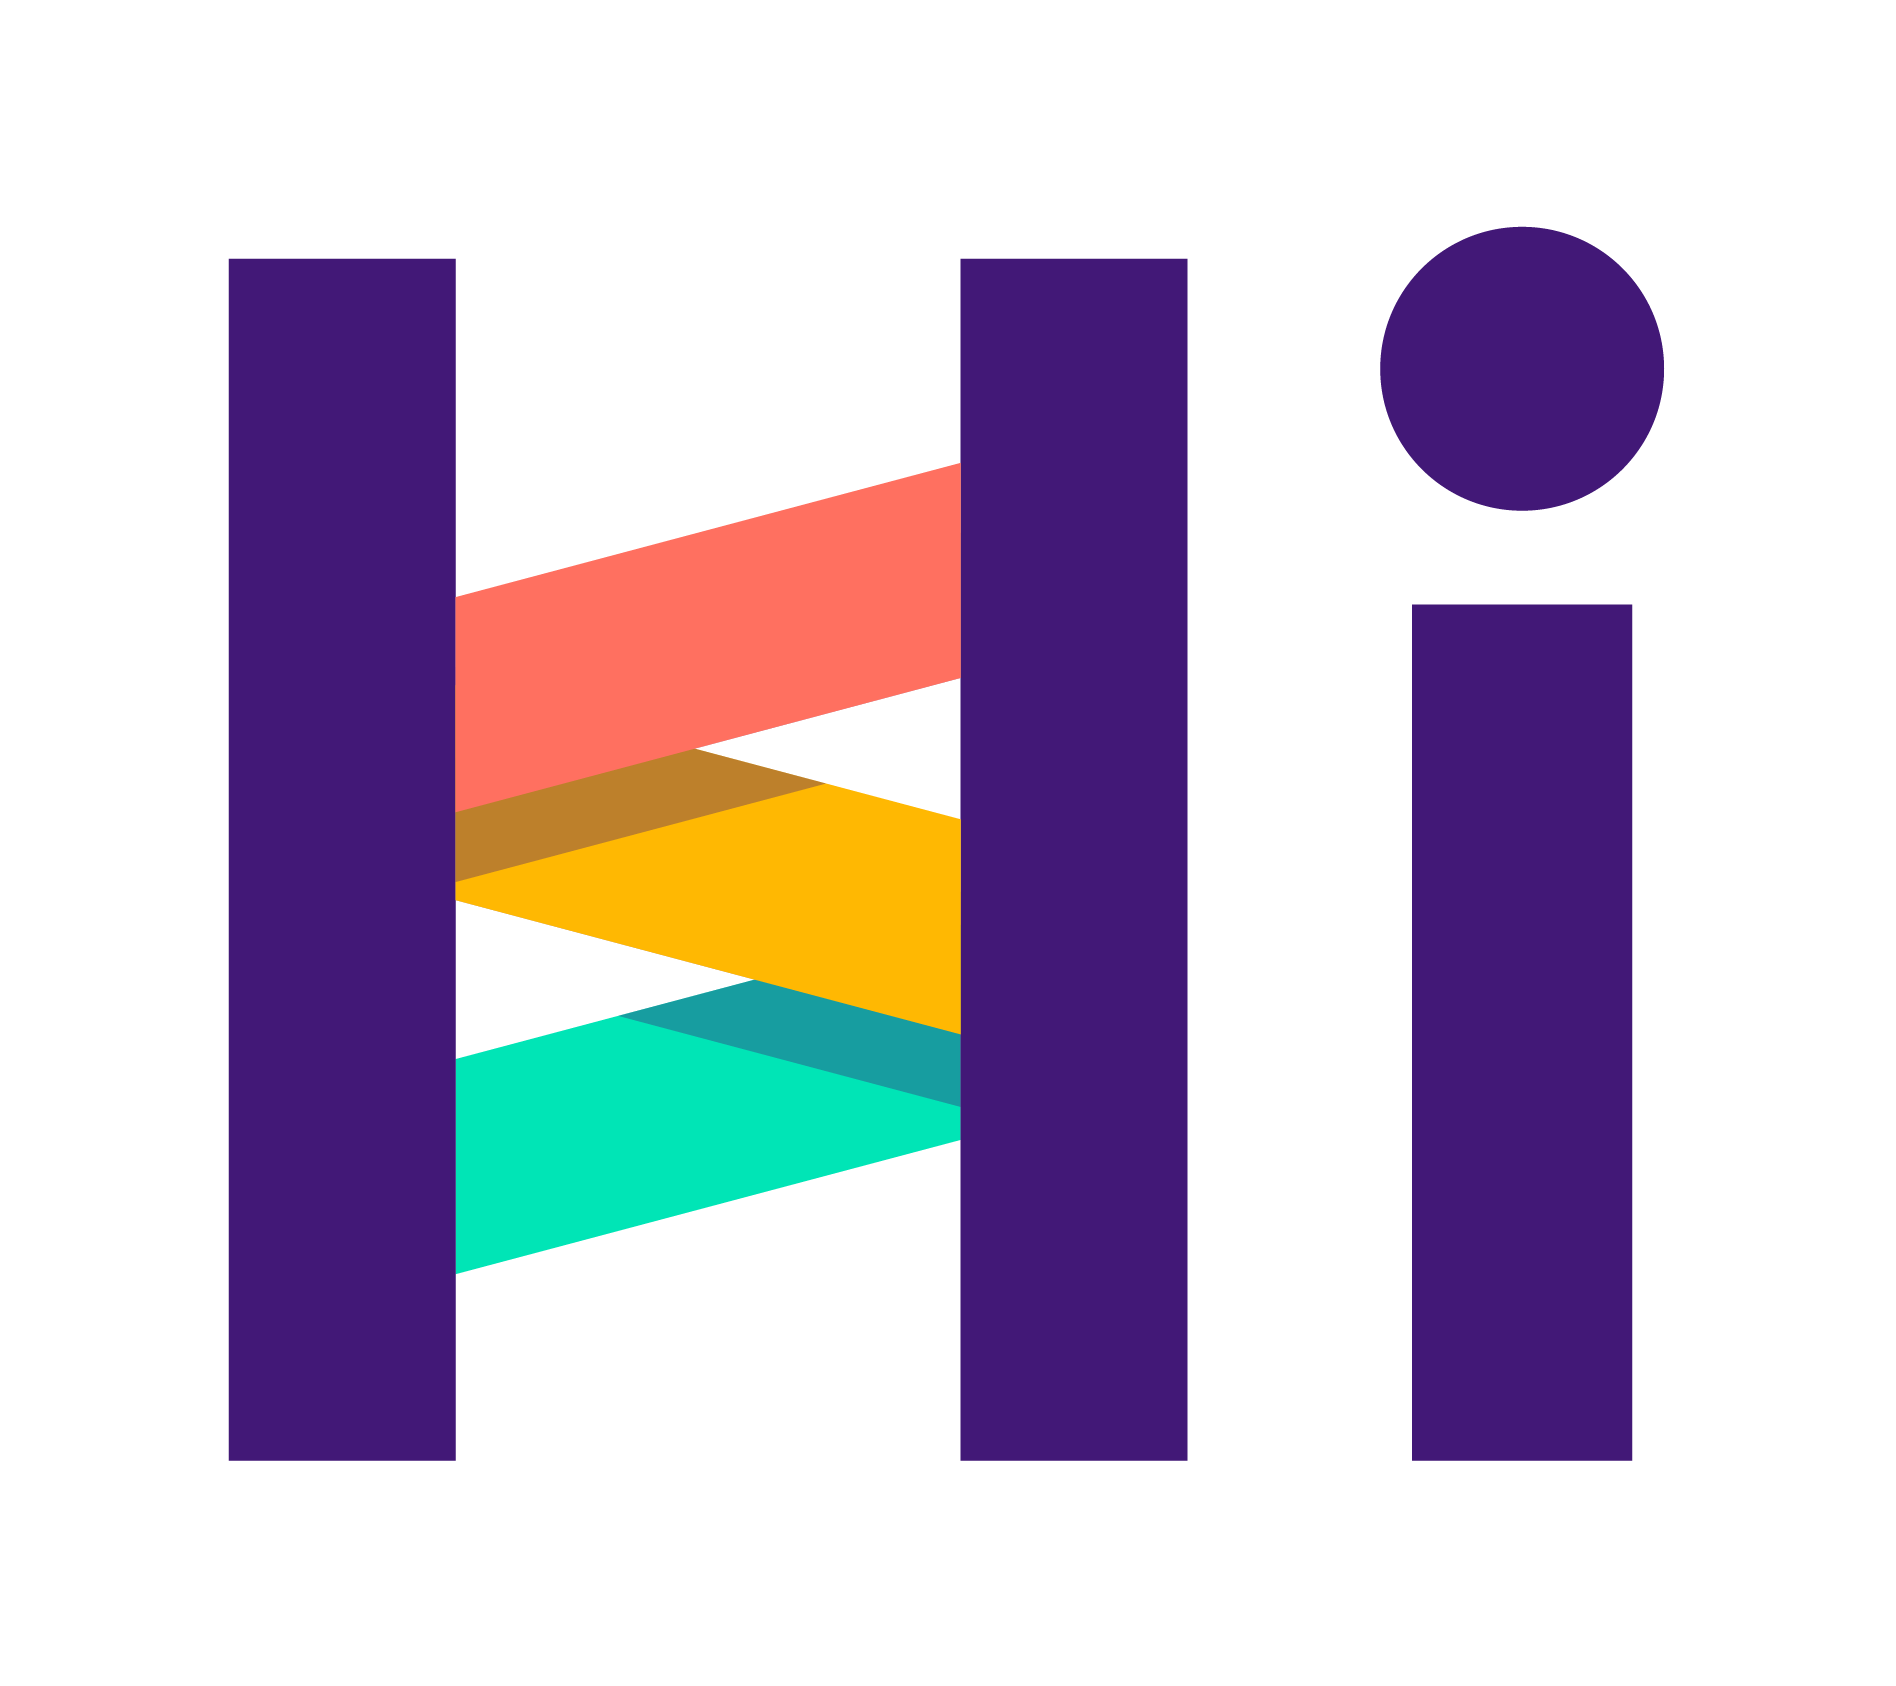

<IPython.core.display.Javascript object>

In [5]:
exp = hip.Experiment.from_iterable(data.values())
for c in ['data_index', 'in_channels', 'pretext', 'freeze']:
    exp.parameters_definition[c].type = hip.ValueType.CATEGORICAL
exp.display_data(hip.Displays.PARALLEL_PLOT).update(
    {
        'hide': ['uid'],
        'order': list(d.keys()),
        'line_thickness': 3.0,
    }
)

# To standalone HTML
# _ = exp.to_html('../hiplots/denoising_comparisons.html')

# In Jupyter Notebook
exp.display();

In [6]:
df = pd.DataFrame.from_dict(data, orient='index')
df = df.reset_index(drop=True, inplace=False)
display(df)

,data_index,in_channels,smoothing,labeled,pretext,freeze,best_epoch,test_accuracy,valid_accuracy,train_accuracy,test_loss,valid_loss,train_loss
0,0,2,0.0,0.1,scratch,0,305,0.764,0.763052,0.909548,0.685626,0.574976,0.239036
1,0,2,0.0,0.1,scratch,2,2330,0.668,0.618474,0.979899,0.872294,1.000152,0.257519
2,0,2,0.0,0.3,scratch,0,261,0.812,0.815261,0.909699,0.543703,0.471284,0.242644
3,0,2,0.0,0.3,scratch,2,1892,0.736,0.751004,0.914716,0.659142,0.655189,0.294244
4,0,2,0.0,0.5,scratch,0,300,0.848,0.855422,0.945837,0.440117,0.389482,0.177026
...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,4,2,0.0,0.7,pirl,2,1171,0.836,0.931727,1.000000,0.480644,0.204803,0.029885
851,4,2,0.0,0.9,pirl,0,336,0.880,0.923695,0.981059,0.409021,0.225678,0.079009
852,4,2,0.0,0.9,pirl,2,1401,0.876,0.907631,0.994986,0.390181,0.231213,0.064984
853,4,2,0.0,1.0,pirl,0,253,0.876,0.927711,0.984962,0.392471,0.178357,0.059330


In [7]:
pivot_configs = {
    #'columns': ['in_channels', 'smoothing'],
    'values': ['test_loss', 'test_accuracy', 'best_epoch'],
    'index': ['freeze', 'pretext', 'labeled'],
    'aggfunc': ['mean', 'std'],
}
table = df.pivot_table(**pivot_configs)
table = table.unstack(level='freeze')
table = table.unstack(level='pretext')
display(table)

mean                                                 \
                 best_epoch                                                  
freeze                    0                                                  
pretext denoising_bernoulli denoising_gaussian   pirl rotation     scratch   
labeled                                                                      
0.1              205.892857              208.0  146.2    359.0  218.689655   
0.3              178.214286              172.8  179.6    314.6  210.448276   
0.5              196.678571              191.8  170.2    309.4  255.655172   
0.7              189.178571                NaN  181.0    376.0  255.766667   
0.9              242.214286                NaN  243.4    446.4  465.275862   
1.0              162.892857                NaN  153.8    607.8  226.200000   

                                                                              \
                                                                               
freeze                    2                                                    
pretext denoising_bernoulli denoising_gaussian    pirl rotation      scratch   
labeled                                                                        
0.1             1302.392857              663.4   582.2   1978.0  2270.068966   
0.3             1219.107143              692.0   651.0   1995.4  2477.533333   
0.5             1253.821429              539.6   726.0   1985.6  2263.233333   
0.7             1262.500000                NaN   754.8   1983.8  2468.068966   
0.9             1846.535714                NaN  1004.0   1956.6  3630.900000   
1.0             1190.500000                NaN   605.2   1968.8  2219.200000   

         ...                 std                                         \
         ...           test_loss                                          
freeze   ...                   2                                          
pretext  ... denoising_bernoulli denoising_gaussian      pirl  rotation   
labeled  ...                                                              
0.1      ...            0.132457           0.066106  0.086641  0.017607   
0.3      ...            0.127810           0.098099  0.060191  0.020648   
0.5      ...            0.147179           0.049626  0.048072  0.022980   
0.7      ...            0.063690                NaN  0.067826  0.034171   
0.9      ...            0.076513                NaN  0.047638  0.019649   
1.0      ...            0.056649                NaN  0.050003  0.041954   

                                                                             \
                                                                              
freeze                              3                                         
pretext   scratch denoising_bernoulli denoising_gaussian      pirl rotation   
labeled                                                                       
0.1      0.122468                 NaN                NaN  0.044655      NaN   
0.3      0.130330                 NaN                NaN  0.050473      NaN   
0.5      0.138565                 NaN                NaN  0.045901      NaN   
0.7      0.071580                 NaN                NaN       NaN      NaN   
0.9      0.074570                 NaN                NaN       NaN      NaN   
1.0      0.085879                 NaN                NaN       NaN      NaN   

                 
                 
freeze           
pretext scratch  
labeled          
0.1         NaN  
0.3         NaN  
0.5         NaN  
0.7         NaN  
0.9         NaN  
1.0         NaN  

[6 rows x 90 columns]

In [16]:
def plot(table, pretexts: list, metric: str, freeze: int, 
         y_min: float = None, y_max: float = None):
    
    y_label = ' '.join([c.capitalize() for c in metric.split('_')])  # e.g. 'test_accuracy' -> 'Test Accuracy'
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    colors = dict(
        scratch='grey', 
        denoising_bernoulli='green', 
        denoising_gaussian='gold', 
        rotation='orangered', 
        pirl='purple')
    
    for pretext in pretexts:
        if pretext == 'scratch':
            label = 'no pretraining'
        else:
            label = pretext
            
        assert pretext in colors.keys()
        color = colors.get(pretext, 'black')
        
        idx = table[('mean', metric, freeze, pretext)].index
        val = table[('mean', metric, freeze, pretext)].values
        std = table[('std', metric, freeze, pretext)].values
        table[('mean', metric, freeze, pretext)].plot.line(
            ax=ax, label=label, color=color)
        ax.scatter(idx, val, marker='^', s=100, color=color)
        ax.fill_between(idx, val-std, val+std, alpha=0.1, color=color)

    ax.set_xlabel('Labeled Data Proportion', fontsize=25)
    ax.set_ylabel(y_label, fontsize=25)
    ax.tick_params(axis='both', which='both', labelsize=25)
    ax.set_xticks([.1, .3, .5, .7, .9, 1.])
    ax.set_xlim(0.0, 1.1)
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)
    ax.legend(loc='best', fontsize=25)
    ax.grid(True)
    ax.set_title(
        f"{y_label} (Freezed: {freeze})",
        fontsize=30
    )

    plt.show(fig)

In [17]:
pretexts = ['scratch', 'denoising_bernoulli', 'denoising_gaussian', 'rotation', 'pirl']

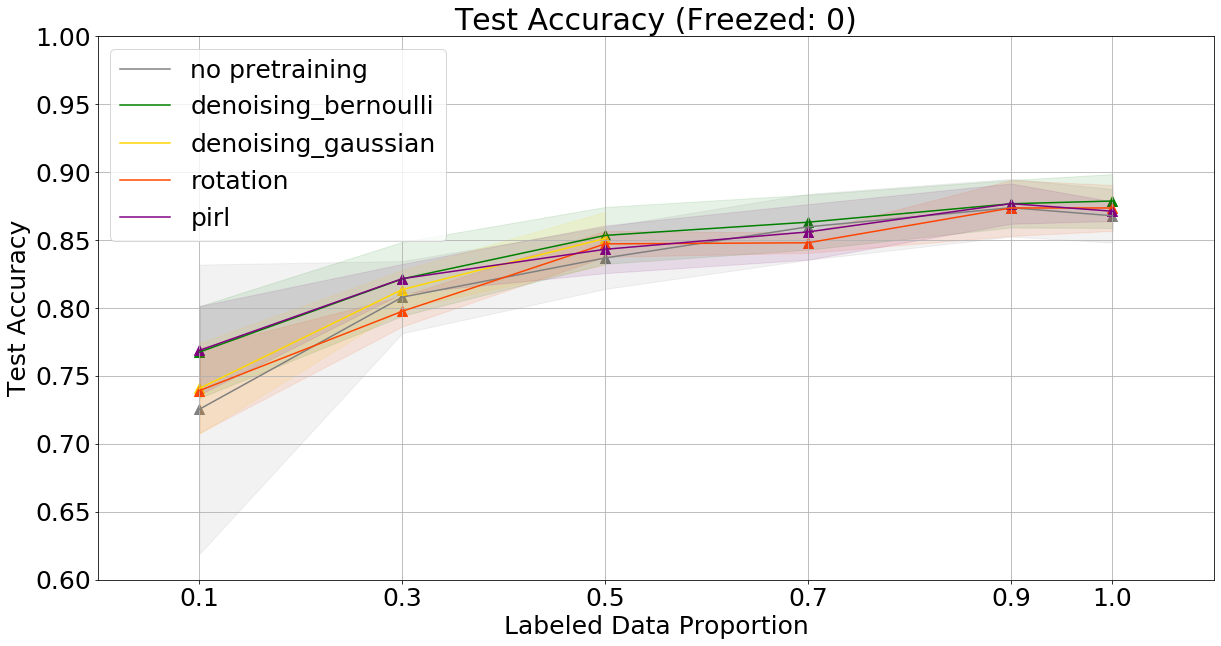

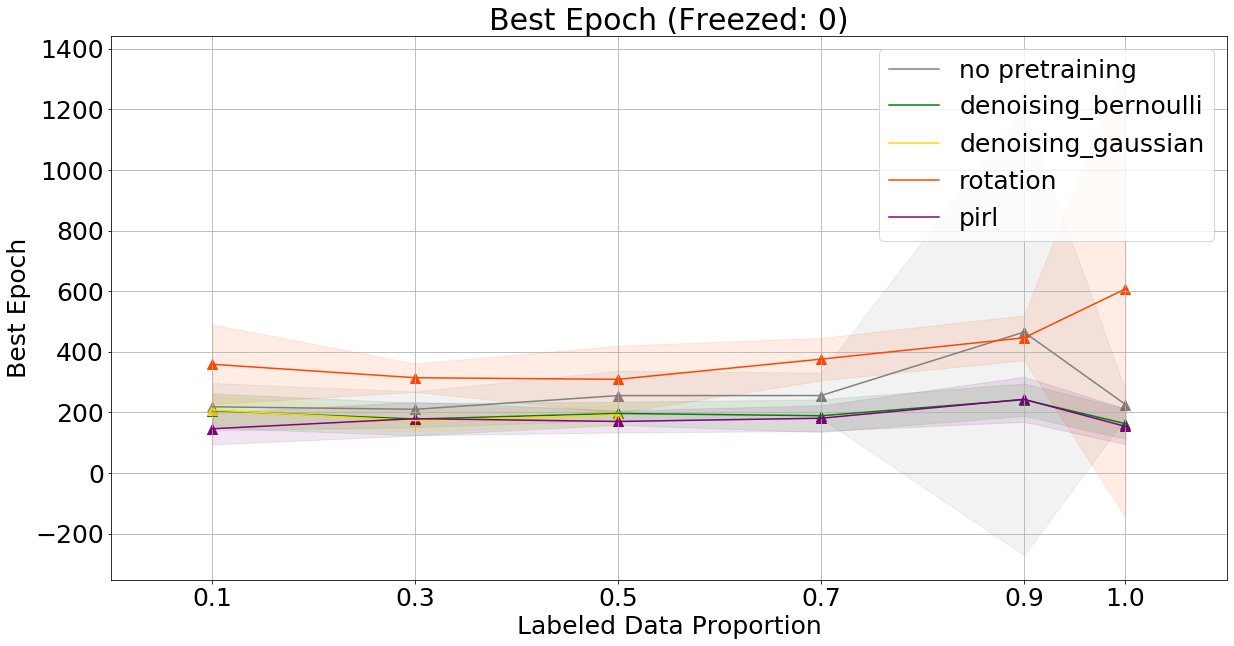

In [18]:
plot(table, pretexts, 'test_accuracy', freeze=0, y_min=.6, y_max=1.)
#plot(table, pretexts, 'test_loss', freeze=0)
plot(table, pretexts, 'best_epoch', freeze=0)

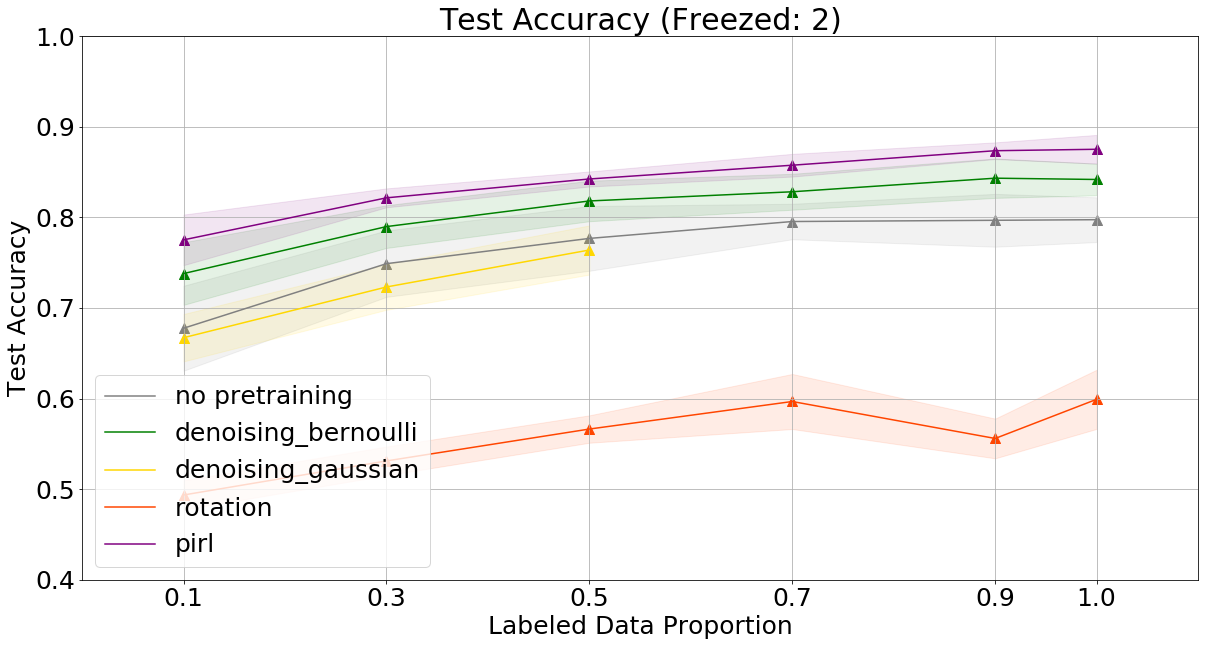

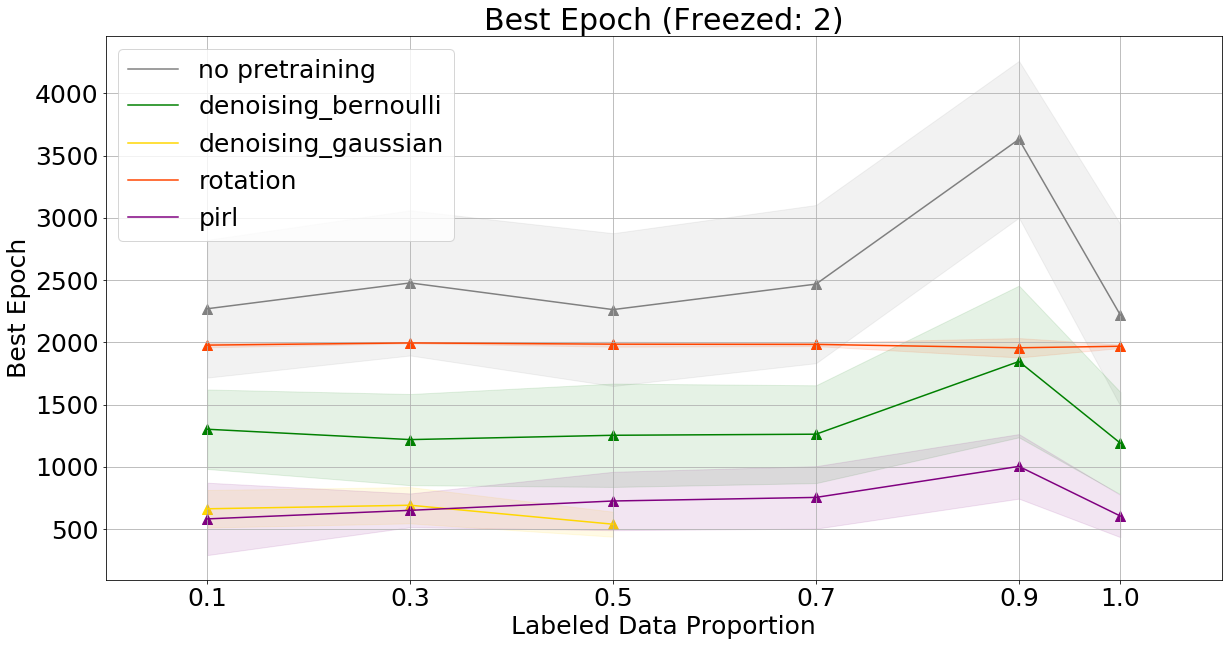

In [19]:
plot(table, pretexts, 'test_accuracy', freeze=2, y_min=.4, y_max=1.)
#plot(table, pretexts, 'test_loss', freeze=2)
plot(table, pretexts, 'best_epoch', freeze=2)